In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from FugacityBinary import Compound
from FugacityPure import PureComponentFugacity
from scipy.optimize import curve_fit, fsolve
import warnings


## Pure Component Fugacity

This example can be found in the book "Engineering and Chemical Thermodynamics" by Milo D. Koretsky.

In [14]:
warnings.filterwarnings("ignore")

compound = PureComponentFugacity(Pc=48.8, Tc=305.4, omega=0.099, name='Ethane',T_stream=273.15+25, P_stream=50)

# Calculate fugacity coefficients using different EOS models
V_m_vdw, Z_vdw, phi_vdw, fugacity_vdw = compound.calculate_fugacity("vdw")
V_m_rk, Z_rk, phi_rk, fugacity_rk = compound.calculate_fugacity("rk")
V_m_srk, Z_srk, phi_srk, fugacity_srk = compound.calculate_fugacity("srk")
V_m_pr, Z_pr, phi_pr, fugacity_pr = compound.calculate_fugacity("pr")

print(f"Van der Waals:\n Molar Volume: {V_m_vdw:.4f} L/mol, Compressibility Factor: {Z_vdw:.4f}, Fugacity Coefficient: {phi_vdw:.4f}, Fugacity: {fugacity_vdw:.1f} bar\n\n")
print(f"Redlich-Kwong:\n Molar Volume: {V_m_rk:.4f} L/mol, Compressibility Factor: {Z_rk:.4f}, Fugacity Coefficient: {phi_rk:.4f}, Fugacity: {fugacity_rk:.1f} bar\n\n")
print(f"Soave-Redlich-Kwong:\n Molar Volume: {V_m_srk:.4f} L/mol, Compressibility Factor: {Z_srk:.4f}, Fugacity Coefficient: {phi_srk:.4f}, Fugacity: {fugacity_srk:.1f} bar\n\n")
print(f"Peng-Robinson:\n Molar Volume: {V_m_pr:.4f} L/mol, Compressibility Factor: {Z_pr:.4f}, Fugacity Coefficient: {phi_pr:.4f}, Fugacity: {fugacity_pr:.1f} bar")

Van der Waals:
 Molar Volume: 0.1307 L/mol, Compressibility Factor: 0.2672, Fugacity Coefficient: 3.5332, Fugacity: 176.7 bar


Redlich-Kwong:
 Molar Volume: 0.5234 L/mol, Compressibility Factor: 1.0697, Fugacity Coefficient: 0.7217, Fugacity: 36.1 bar


Soave-Redlich-Kwong:
 Molar Volume: 0.2253 L/mol, Compressibility Factor: 0.4604, Fugacity Coefficient: 0.6258, Fugacity: 31.3 bar


Peng-Robinson:
 Molar Volume: 0.2116 L/mol, Compressibility Factor: 0.4324, Fugacity Coefficient: 0.6035, Fugacity: 30.2 bar


# Benzene and Toluene Binary Mixture

* importação de dados experimentais
* ajuste de curvas e obtenção de coeficientes de interação
    * Fase vapor: coeficiente de fugacidade a partir de EoS
        * A partir de modelos de mistura, verificar se fase vapor se comporta como gás ideal
        * Modelagem de mistura em fase vapor considerando equações cúbicas
        * Modelos de mistura: *"Fugacity Coefficients from the Generic Cubic Equation of State"* - Van Ness (Ch. 13.7)
    * Fase líquida: coeficientes de interação binária 
    * Formulação **Modelo de Margules 2 parâmetros**:
      
        * $\frac{G^E}{x_1x_2RT}=A_{21}x_1+A_{12}x_2=A_{12}+(A_{21}-A_{12})x_1\rightarrow \frac{G^E}{RT}=(A_{21}x_1+A_{12}x_2)x_1x_2$
          
        * Multiplicando por ambos os lados $n$: $\frac{nG^E}{RT}=(A_{21}n_1+A_{12}n_2) \frac{n_1n_2}{(n_1+n_2)^2}$
          
        * Visto que:
          
            + $ln \gamma_1=\biggl[\frac{ \partial (nG^E/RT)}{ \partial n_1}\biggl]_{T,P,n_2} \rightarrow ln \gamma_1=x^2_2[A_{12}+2(A_{21}-A_{12})x_1]$
              
            + $ln \gamma_2=\biggl[\frac{ \partial (nG^E/RT)}{ \partial n_2}\biggl]_{T,P,n_1} \rightarrow ln \gamma_1=x^2_1[A_{21}+2(A_{12}-A_{21})x_2]$
          
        * Por definição: $\gamma_i = \frac{\hat f^l_i}{\hat f^{id}_l}\;\;\ sendo\;\; f^l_i=exp \biggl[\frac{V^l_i(P-P^{sat}_i)}{RT}\biggl] \hat \phi^{sat}_i\;P^{sat}_i\; \therefore \; \gamma_i = \frac{y_i\;P}{x_i\;P^{sat}_i}$

In [ ]:
df_raw = pd.read_excel('pxy_data_benzene_toluene.xlsx')
# por balanço de massa x_toluene = 1 - x_benzene
df_raw['x_toluene'] = 1 - df_raw['x_benzene']
df_complete = df_raw
df_complete

,P [kPa],x_benzene,x_toluene
0,18.3,0.000,1.000
1,21.7,0.104,0.896
2,24.8,0.202,0.798
3,28.3,0.303,0.697
4,31.7,0.398,0.602
5,35.1,0.505,0.495
6,38.1,0.601,0.399
7,42.0,0.696,0.304
8,45.5,0.803,0.197
9,47.2,0.845,0.155


## Modelagem Fase Vapor

Considerações de engenharia química:
* Substâncias similares (químicamente)
* Interação intermolecular: ambas apolares e não apresentam forças significativas de atração
* Propriedades críticas possuem alta similaridade - podem apresentar dificuldades de separação eficiente
  
Modelagem:
* Utilização de EoS para representação do comportamento de interação
  
* EoS: Redlich/Kwong $\biggl(P + \frac{a}{T^{0.5}\; \underbar V\;(\underbar V + b)}\biggl)= \frac{RT}{(\underbar V\;-b)}$
  
* Modelo coeficiente de fugacidade em misturas 

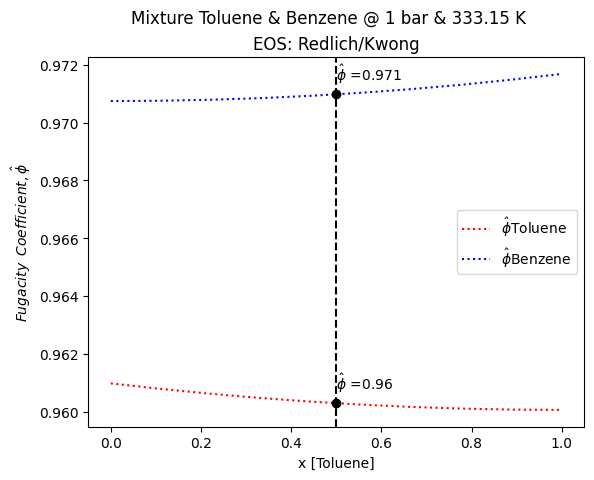

In [ ]:
P_stream = 1 # bar
T_stream = 333.15 # K
mass_fraction = 0.5

name_compounds = list()
labels = list()

# ================ Substance INPUTS ================
TOLUENE = Compound(41.08, 318.6+273.15, 92.141, 0.264, 'Toluene',
                   T_stream, P_stream)
BENZENE = Compound(48.95, 288.9+273.15, 78.114, 0.209, 'Benzene',
                   T_stream, P_stream)
# =================================================

# =============== DATA MANIUPULATION ===============
for i in Compound.records_from_compound:
    name_compounds.append(i.name)
    for compound in Compound.records_from_compound:
        # apenas elementos únicos devem ser adicionados
        if compound.name not in labels:
            labels.append(str(compound.name))

EOS_BASE = int(input('Escolha a EOS base: \n0 - Van der Waals\n1 - Redlich/Kwong\n2 - Soave-Redlich/Kwong\n3 - Peng Robinson\n'))
EOS_DICT = {0: 'Van der Waals', 1: 'Redlich/Kwong', 2: 'Soave-Redlich/Kwong', 3: 'Peng Robinson'}

elv = Compound.mixing_rule(TOLUENE, BENZENE, EOS_BASE, mass_fraction)

x = np.linspace(0, 1, 10)
phi_variation = [Compound.mixing_rule(TOLUENE, BENZENE, EOS_BASE, i) for i in x]

comp1 = [ i[0] for i in phi_variation ]
comp2 = [ i[1] for i in phi_variation ]
# =================================================

def plotting_binary(phi1, phi2, x, labels):
    plt.plot(x, phi1, 'r:', label=r'$\hat{\phi}$'+labels[0])
    plt.plot(x, phi2, 'b:', label=r'$\hat{\phi}$'+labels[1])
    plt.plot(mass_fraction, elv[0], 'ko')
    plt.plot(mass_fraction, elv[1], 'ko')
    plt.annotate('$\hat{\phi}$ ='+f'{round(elv[0],3)}', (mass_fraction, elv[0]), textcoords="offset points", xytext=(0,10), ha='left')
    plt.annotate('$\hat{\phi}$ ='+f'{round(elv[1],3)}', (mass_fraction, elv[1]), textcoords="offset points", xytext=(0,10), ha='left')
    plt.axvline(x=mass_fraction, color='k', linestyle='--')
    plt.title(f'EOS: {[i for i in EOS_DICT.values()][EOS_BASE]}')
    plt.suptitle(f'Mixture {name_compounds[0]} & {name_compounds[1]} @ {P_stream} bar & {T_stream} K')
    plt.xlabel(f'x [{name_compounds[0]}]')
    plt.ylabel(r'$Fugacity\;\;Coefficient, \hat{\phi}$')
    plt.legend(loc='best')
    plt.show()
plotting_binary(comp1, comp2, x, labels)

É possível observar que para as condições de processo adotadas, o comportamento da mistura é próximo das considerações de gases ideais ($\hat \phi_i \rightarrow 1$). Assim, para modelagem para obtenção do coeficiente de atividade consideraremos a fase vapor como ideal e, portanto, a modelagem do sistema em fase líquida contemplará a Lei de Raoult Modificada ($\hat \phi_i = 1$)

In [ ]:
# from experimental data
T_exp = 333.15-273.15 # K

# Antoine's equation to calculate Psat
def antoine(A, B, C, T):
    return (np.exp(A - B/(T + C)))

# Antoine's parameter benzene & toluene - Table B.2 Van Ness
A_ben, B_ben, C_ben = 13.7819, 2726.81, 217.572
A_tol, B_tol, C_tol = 13.9320, 3056.96, 217.625

# psat benzene & toluene
P_ben = antoine(A_ben, B_ben, C_ben, T_exp)
P_tol = antoine(A_tol, B_tol, C_tol, T_exp)

**Benzene & Toluene modelling**

In [ ]:
# calculate vapor fraction from Raoult's Law
y1_exp = list() # will be our shot to calculate y1 from Modified Raoult's Law
P_calculated = list()

for x1 in df_complete['x_benzene']:
    Pt_calc = x1 * P_ben + (1-x1) * P_tol
    P_calculated.append(Pt_calc)
    y1_calc = x1 * P_ben / Pt_calc
    y1_exp.append(y1_calc)

In [ ]:
for i, _ in enumerate(P_calculated):
    print(f'x1 = {df_complete["x_benzene"][i]}\ty1 = {round(y1_exp[i],3)}\tP_calculated = {round(P_calculated[i], 2)} kPa')

x1 = 0.0	y1 = 0.0	P_calculated = 18.56 kPa
x1 = 0.104	y1 = 0.247	P_calculated = 22.07 kPa
x1 = 0.202	y1 = 0.417	P_calculated = 25.39 kPa
x1 = 0.303	y1 = 0.551	P_calculated = 28.8 kPa
x1 = 0.398	y1 = 0.651	P_calculated = 32.01 kPa
x1 = 0.505	y1 = 0.742	P_calculated = 35.63 kPa
x1 = 0.601	y1 = 0.81	P_calculated = 38.87 kPa
x1 = 0.696	y1 = 0.866	P_calculated = 42.08 kPa
x1 = 0.803	y1 = 0.92	P_calculated = 45.7 kPa
x1 = 0.845	y1 = 0.939	P_calculated = 47.12 kPa
x1 = 1.0	y1 = 1.0	P_calculated = 52.36 kPa


In [ ]:
# deviation of pressure calcultaed from experimental data
deviation = list()
for i in df_complete['P [kPa]']:
    dev = [(P_calculated[j] - i) / i for j in range(len(P_calculated))]
    deviation.append(dev)

for i, _ in enumerate(deviation):
    print(f'Experimental: {df_complete["P [kPa]"][i]}\tCalculated: {round(P_calculated[i],2)}\tDeviation: {round(deviation[i][i]*100, 3)}%')

Experimental: 18.3	Calculated: 18.56	Deviation: 1.409%
Experimental: 21.7	Calculated: 22.07	Deviation: 1.719%
Experimental: 24.8	Calculated: 25.39	Deviation: 2.361%
Experimental: 28.3	Calculated: 28.8	Deviation: 1.764%
Experimental: 31.7	Calculated: 32.01	Deviation: 0.979%
Experimental: 35.1	Calculated: 35.63	Deviation: 1.501%
Experimental: 38.1	Calculated: 38.87	Deviation: 2.026%
Experimental: 42.0	Calculated: 42.08	Deviation: 0.197%
Experimental: 45.5	Calculated: 45.7	Deviation: 0.438%
Experimental: 47.2	Calculated: 47.12	Deviation: -0.172%
Experimental: 52.0	Calculated: 52.36	Deviation: 0.689%


In [ ]:
y2_exp = list([i for i in map(lambda x: 1-x, y1_exp)])

# appending benzene & toluene calculated data into dataframe
df_complete['y1_benzene'] = y1_exp
df_complete['y2_toluene'] = y2_exp

df_complete

,P [kPa],x_benzene,x_toluene,y1_benzene,y2_toluene
0,18.3,0.000,1.000,0.000000,1.000000
1,21.7,0.104,0.896,0.246693,0.753307
2,24.8,0.202,0.798,0.416630,0.583370
3,28.3,0.303,0.697,0.550865,0.449135
4,31.7,0.398,0.602,0.650994,0.349006
5,35.1,0.505,0.495,0.742159,0.257841
6,38.1,0.601,0.399,0.809514,0.190486
7,42.0,0.696,0.304,0.865941,0.134059
8,45.5,0.803,0.197,0.920002,0.079998
9,47.2,0.845,0.155,0.938954,0.061046


In [ ]:
gamma1 = [(df_complete['y1_benzene'][i]*df_complete['P [kPa]'][i])/(P_ben*df_complete['x_benzene'][i]) for i in range(len(df_complete['y1_benzene']))]
gamma2 = [(df_complete['y2_toluene'][i]*df_complete['P [kPa]'][i])/(P_tol*df_complete['x_toluene'][i]) for i in range(len(df_complete['y2_toluene']))]

C:\Users\gabri\AppData\Local\Temp\ipykernel_13508\2762307997.py:1: RuntimeWarning: invalid value encountered in scalar divide
  gamma1 = [(df_complete['y1_benzene'][i]*df_complete['P [kPa]'][i])/(P_ben*df_complete['x_benzene'][i]) for i in range(len(df_complete['y1_benzene']))]
C:\Users\gabri\AppData\Local\Temp\ipykernel_13508\2762307997.py:2: RuntimeWarning: invalid value encountered in scalar divide
  gamma2 = [(df_complete['y2_toluene'][i]*df_complete['P [kPa]'][i])/(P_tol*df_complete['x_toluene'][i]) for i in range(len(df_complete['y2_toluene']))]


In [ ]:
df_complete['gamma1'] = gamma1
df_complete['gamma2'] = gamma2
df_complete

,P [kPa],x_benzene,x_toluene,y1_benzene,y2_toluene,gamma1,gamma2
0,18.3,0.000,1.000,0.000000,1.000000,NaN,0.986111
1,21.7,0.104,0.896,0.246693,0.753307,0.983102,0.983102
2,24.8,0.202,0.798,0.416630,0.583370,0.976939,0.976939
3,28.3,0.303,0.697,0.550865,0.449135,0.982664,0.982664
4,31.7,0.398,0.602,0.650994,0.349006,0.990307,0.990307
5,35.1,0.505,0.495,0.742159,0.257841,0.985210,0.985210
6,38.1,0.601,0.399,0.809514,0.190486,0.980146,0.980146
7,42.0,0.696,0.304,0.865941,0.134059,0.998033,0.998033
8,45.5,0.803,0.197,0.920002,0.079998,0.995636,0.995636
9,47.2,0.845,0.155,0.938954,0.061046,1.001718,1.001718


In [ ]:
# Raoult's Model
Raoults_model = lambda x1, x2, psat1, psat2: x1 * psat1 + x2 * psat2

raoults_fit = Raoults_model(df_complete['x_benzene'], df_complete['x_toluene'], P_ben, P_tol)

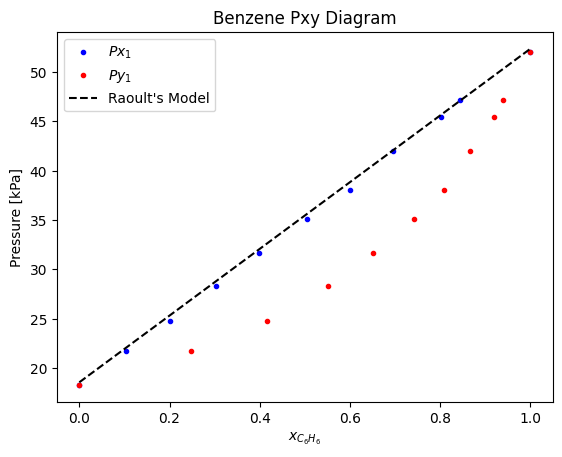

In [ ]:
# plotting Pxy diagram
plt.plot(df_complete['x_benzene'], df_complete['P [kPa]'], 'b.', label='$Px_1$')
plt.plot(df_complete['y1_benzene'], df_complete['P [kPa]'], 'r.', label='$Py_1$')

plt.plot(df_complete['x_benzene'], raoults_fit, 'k--', label='Raoult\'s Model')

plt.title('Benzene Pxy Diagram')
plt.xlabel('$x_{C_6H_6}$')
plt.ylabel('Pressure [kPa]')
plt.legend(loc='best')

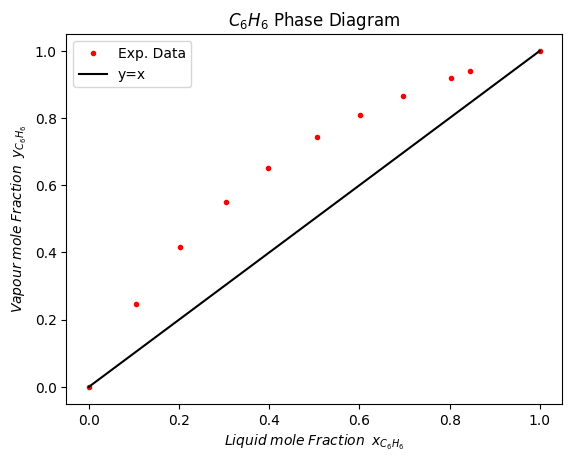

In [ ]:
# plotting x1, y1
plt.plot(df_complete['x_benzene'], df_complete['y1_benzene'], 'r.', label='Exp. Data')
plt.plot(np.linspace(0,1), np.linspace(0,1), 'k-', label='y=x')
plt.legend(loc='best')
plt.title('$C_6H_6$ Phase Diagram')
plt.xlabel('$Liquid\;mole\;Fraction\;\;x_{C_6H_6}$')
plt.ylabel('$Vapour\;mole\;Fraction\;\;y_{C_6H_6}$');

**Useful Thermodynamics**

In [ ]:
log_gamma1 = [np.log(i) for i in gamma1]
log_gamma2 = [np.log(i) for i in gamma2]


excess_gibbs_RT_exp = [df_complete['x_benzene'][i]*log_gamma1[i] + df_complete['x_toluene'][i]*log_gamma2[i] for i in range(len(df_complete['x_benzene']))]
excess_gibbs_RT_exp = np.where(np.isnan(excess_gibbs_RT_exp), 0, excess_gibbs_RT_exp)
excess_gibbs_RTx1x2_exp= [excess_gibbs_RT_exp[i] / (df_complete['x_benzene'][i]*df_complete['x_toluene'][i]) for i in range(len(df_complete['x_benzene']))]
excess_gibbs_RTx1x2_exp = np.where(np.isnan(excess_gibbs_RTx1x2_exp), 0, excess_gibbs_RTx1x2_exp)

C:\Users\gabri\AppData\Local\Temp\ipykernel_13508\3167594409.py:7: RuntimeWarning: invalid value encountered in scalar divide
  excess_gibbs_RTx1x2_exp= [excess_gibbs_RT_exp[i] / (df_complete['x_benzene'][i]*df_complete['x_toluene'][i]) for i in range(len(df_complete['x_benzene']))]


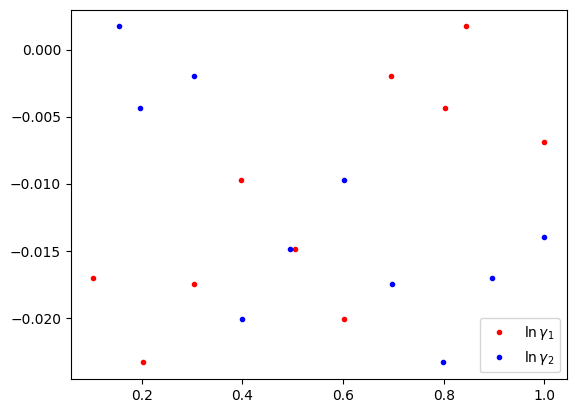

In [ ]:
# plotting experimental data
plt.plot(df_complete['x_benzene'], log_gamma1, 'r.', label=r'$\ln\gamma_1$')
plt.plot(df_complete['x_toluene'], log_gamma2, 'b.', label=r'$\ln\gamma_2$')
plt.legend(loc='best');

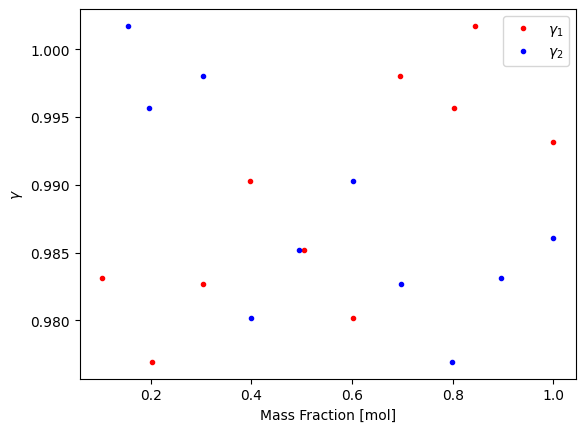

In [ ]:
# plotting experimental data
plt.plot(df_complete['x_benzene'], df_complete['gamma1'], 'r.', label=r'$\gamma_1$')
plt.plot(df_complete['x_toluene'], df_complete['gamma2'], 'b.', label=r'$\gamma_2$')
plt.xlabel('Mass Fraction [mol]')
plt.ylabel('$\gamma$')
plt.legend(loc='best');

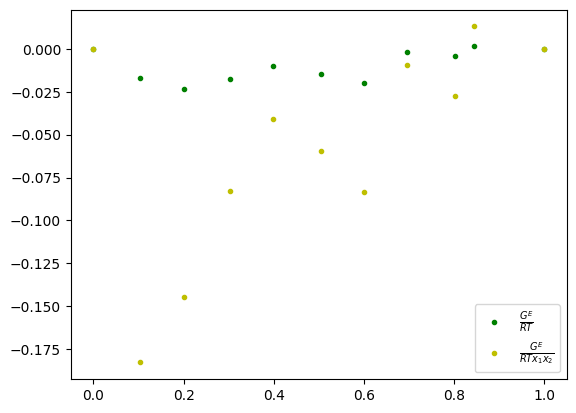

In [ ]:
plt.plot(df_complete['x_benzene'], excess_gibbs_RT_exp, 'g.', label=r'$\frac{G^E}{RT}$')
plt.plot(df_complete['x_benzene'], excess_gibbs_RTx1x2_exp, 'y.', label=r'$\frac{G^E}{RTx_1x_2}$')
plt.legend(loc='best');

All plots seem a little randomic, and that can be explained by the fact that the $\gamma$ coefficients are near the same value ($\gamma$ ~ 1), proving our the hypothesis that the liquid behaviour can be considered ideal.

# Example 8.9 Koretsky

Liquid-vapor equilibrium data have been collected for a binary system of benzene (1) - cyclohaxane (2) at 10°C. Mole fraction of liquid and vapor vs. total pressure are reported on the table data. From these data, determine the value of the two-suffix Margules parameter A.
  
Table E8.9A - Measured Px Data for Benzene(1)-Cyclohexane(2) at 10°C.
  

| $x_1$ | $x_2$ | P [Pa] |
|----------|----------|----------|
|0|0|6344|
|0.0610|0.0953|6590|
|0.2149|0.2710|6980|
|0.3187|0.3600|7140|
|0.4320|0.4453|7171|
|0.5246|0.5106|7216|
|0.6117|0.5735|7140|
|0.7265|0.6626|6974|
|0.8040|0.4312|6845|
|0.8830|0.8200|6617|
|0.8999|0.8382|6557|
|1|1|6073|


Considerações:
* Compostos similares $\rightarrow$ Correção por Poyinting = 1
* Pressão baixa $\rightarrow$ gás ideal ($\phi_i = 1$)
  
Modelagem Margules 2-sufixos:
  
* $P=x_1 \gamma_1 P^{sat}_1+(1-x_1) \gamma_2 P^{sat}_2$ (I)

Para misturas binárias: 
* $ \bar G^E_a=Ax^2_b=RT\;Ln\;\gamma_a$ então, isolando coef. fugacidade: $Ln\;\gamma_1=\frac{A}{RT}(1-x_1)^2$  (II)
* $ \bar G^E_a=Ax^2_a=RT\;Ln\;\gamma_b$ então, isolando coef. fugacidade: $Ln\;\gamma_2=\frac{A}{RT}x^2_1$      (III)
  
Substituindo (II) e (III) em (I):
  
$P_{calc}=x_1exp\biggl[\frac{A}{RT}(1-x_1)^2\biggl]P^{sat}_1+(1-x_1)exp\biggl[\frac{A}{RT}x^2_1\biggl]P^{sat}_2$ (IV)
  
Nosso objetivo: obter pressões calculadas a partir do ajuste e realizar otimização para obter valor real de A
* Modelagem a partir da Eq. (IV)
* Plotar os resultados
* Determinação de função objetivo
* Otimização para obter melhor ajuste

In [ ]:
df_KRTZ_8_9 = pd.DataFrame({'x1': [0., 0.0610, 0.2149, 0.3187, 0.4320, 0.5246, 0.6117, 0.7265, 0.8040, 0.8830, 0.8999, 1.],
                            'y1': [0., 0.0953, 0.2710, 0.3600, 0.4453, 0.5106, 0.5735, 0.6626, 0.7312, 0.8200, 0.8382, 1.],
                            'P[Pa]': [6344, 6590, 6980, 7140, 7171, 7216, 7140, 6974, 6845, 6617, 6557, 6073]})

df_KRTZ_8_9

,x1,y1,P[Pa]
0,0.0000,0.0000,6344
1,0.0610,0.0953,6590
2,0.2149,0.2710,6980
3,0.3187,0.3600,7140
4,0.4320,0.4453,7171
5,0.5246,0.5106,7216
6,0.6117,0.5735,7140
7,0.7265,0.6626,6974
8,0.8040,0.7312,6845
9,0.8830,0.8200,6617


In [ ]:
R = 8.314 # J/mol.K
T = 10 + 273.15 # K
shot_A = 2000  # J/mol

# Antoine's parameter benzene & cyclohexane - Table B.2 Van Ness
A_ben, B_ben, C_ben = 13.7819, 2726.81, 217.572
A_chx, B_chx, C_chx = 13.6568, 2723.44, 220.618

# psat benzene & cyclohexane - pressure in kPa
P_ben = antoine(A_ben, B_ben, C_ben, T-273.15) 
P_chx = antoine(A_chx, B_chx, C_chx, T-273.15)

# function to be optimized
p_calc = lambda x, A: x*np.exp((A/R/T)*((1-x)**2))*P_ben + (1-x)*np.exp((A/R/T)*(x**2))*P_chx
p_calc_init = [p_calc(df_KRTZ_8_9['x1'][i], shot_A) for i in range(len(df_KRTZ_8_9['x1']))]

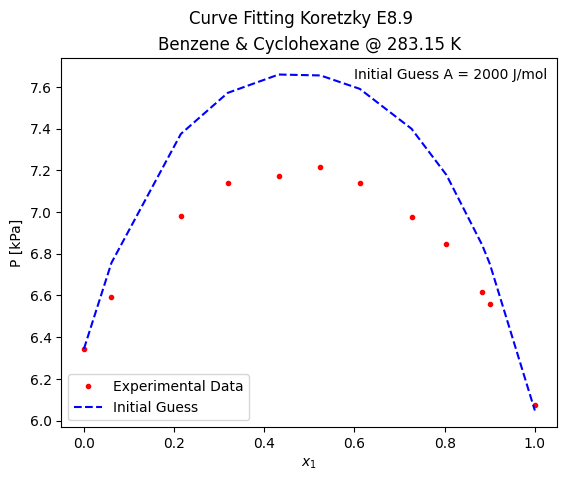

In [ ]:
# initial plot based on guess
plt.plot(df_KRTZ_8_9['x1'], df_KRTZ_8_9['P[Pa]']*1E-3, 'r.', label='Experimental Data')
plt.plot(df_KRTZ_8_9['x1'], p_calc_init, 'b--', label='Initial Guess')
plt.ylabel('P [kPa]')
plt.xlabel('$x_1$')
plt.annotate(f'Initial Guess A = {shot_A} J/mol', (0.6, 7.57), textcoords="offset points", xytext=(0,10), ha='left')
plt.suptitle('Curve Fitting Koretzky E8.9')
plt.title(f'Benzene & Cyclohexane @ {T} K')
plt.legend(loc='best');

In [ ]:
# using curve_fit to optimize A
popt, pcov = curve_fit(p_calc, df_KRTZ_8_9['x1'], df_KRTZ_8_9['P[Pa]']*1E-3, p0=shot_A)
print(f'Optimized A = {popt[0]} J/mol')

Optimized A = 1424.6076482828414 J/mol


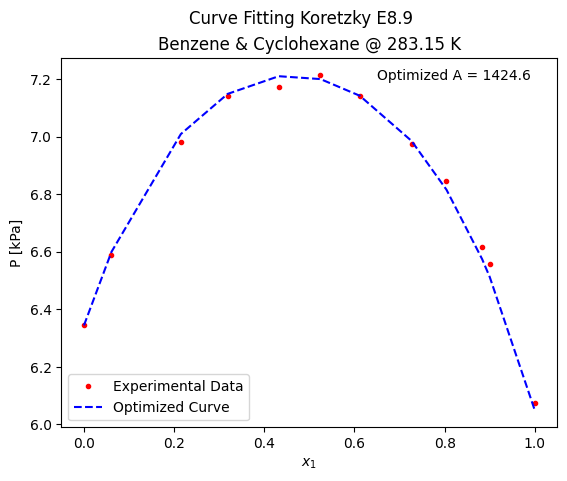

In [ ]:
# optimized plot
plt.plot(df_KRTZ_8_9['x1'], df_KRTZ_8_9['P[Pa]']*1E-3, 'r.', label='Experimental Data')
plt.plot(df_KRTZ_8_9['x1'], p_calc(df_KRTZ_8_9['x1'], popt[0]), 'b--', label='Optimized Curve')
plt.ylabel('P [kPa]')
plt.xlabel('$x_1$')
plt.annotate(f'Optimized A = {round(popt[0],1)}', (0.65, 7.15), textcoords="offset points", xytext=(0,10), ha='left')
plt.suptitle('Curve Fitting Koretzky E8.9')
plt.title(f'Benzene & Cyclohexane @ {T} K')
plt.legend(loc='best');

In [ ]:
# =============== PRE OPTIMIZATION ===============
disparity = [(df_KRTZ_8_9['P[Pa]'][i]*1E-3 - p_calc_init[i])**2 for i in range(len(df_KRTZ_8_9['P[Pa]']))]
gamma1_ = [np.exp((shot_A/R/T)*((1-df_KRTZ_8_9['x1'])[i])**2) for i in range(len(df_KRTZ_8_9['x1']))]
gamma2_ = [np.exp((shot_A/R/T)*(df_KRTZ_8_9['x1'][i])**2) for i in range(len(df_KRTZ_8_9['x1']))]

print('=============== PRE OPTIMIZATION ===============')
print(f'A={round(shot_A,2)} J/mol\t SUM OF SQRD ERROR = [{round(sum(disparity), 2)}]')
print('='*48)
dataframe_unopt = pd.DataFrame({'gamma1':[i for i in gamma1_],
                               'gamma2':[i for i in gamma2_],
                               'P[Pa]':[i*1E3 for i in p_calc_init],
                               'P²_err':[i for i in disparity]})
print(dataframe_unopt)

=============== PRE OPTIMIZATION ===============
A=2000 J/mol	 SUM OF SQRD ERROR = [1.38]
      gamma1    gamma2        P[Pa]        P²_err
0   2.338660  1.000000  6343.861362  1.922060e-08
1   2.115077  1.003166  6756.047450  2.757176e-02
2   1.688203  1.040015  7374.017158  1.552495e-01
3   1.483417  1.090124  7570.839938  1.856231e-01
4   1.315339  1.171813  7658.994436  2.381386e-01
5   1.211682  1.263402  7654.607243  1.923763e-01
6   1.136663  1.374229  7590.264723  2.027383e-01
7   1.065613  1.565820  7398.873632  1.805176e-01
8   1.033176  1.731834  7177.201767  1.103580e-01
9   1.011698  1.939455  6842.306565  5.076305e-02
10  1.008549  1.989743  6752.578179  3.825082e-02
11  1.000000  2.338660  6047.918373  6.290880e-04


In [ ]:
print(30*'='+' POST OPTIMIZATION '+30*'=')
# function optimized
p_calc_opt = p_calc(df_KRTZ_8_9['x1'], popt[0])
optimal = [(df_KRTZ_8_9['P[Pa]'][i]*1E-3 - p_calc_opt[i])**2 for i in range(len(df_KRTZ_8_9['P[Pa]']))]
print(f'A={round(popt[0],2)} J/mol\t SUM OF SQRD ERROR = [{round(sum(optimal), 2)}]')
print('='*79)

gamma1_opt = [np.exp((popt[0]/R/T)*((1-df_KRTZ_8_9['x1'])[i])**2) for i in range(len(df_KRTZ_8_9['x1']))]
gamma2_opt = [np.exp((popt[0]/R/T)*(df_KRTZ_8_9['x1'][i])**2) for i in range(len(df_KRTZ_8_9['x1']))]

dataframe_opt = pd.DataFrame({'gamma1 optimal':[i for i in gamma1_opt],
                               'gamma2 optimal':[i for i in gamma2_opt],
                               'P[Pa]':[i*1E3 for i in p_calc_opt],
                               'P²_err':[i for i in optimal]})
print(dataframe_opt)

print(f'Optimized A={round(popt[0],2)} J/mol \tDisparity = {round(sum(optimal), 2)}')
print('='*79)

============================== POST OPTIMIZATION ==============================
A=1424.61 J/mol	 SUM OF SQRD ERROR = [0.01]
    gamma1 optimal  gamma2 optimal        P[Pa]        P²_err
0         1.831541        1.000000  6343.861362  1.922060e-08
1         1.705026        1.002254  6599.337972  8.719772e-05
2         1.452097        1.028342  7009.009263  8.415373e-04
3         1.324316        1.063394  7148.647360  7.477684e-05
4         1.215601        1.119561  7210.131499  1.531274e-03
5         1.146563        1.181214  7200.133395  2.517491e-04
6         1.095536        1.254122  7142.255184  5.085853e-06
7         1.046307        1.376307  6985.234320  1.262100e-04
8         1.023520        1.478730  6815.541788  8.677862e-04
9         1.008318        1.602933  6574.482490  1.807739e-03
10        1.006082        1.632429  6512.249530  2.002605e-03
11        1.000000        1.831541  6047.918373  6.290880e-04
Optimized A=1424.61 J/mol 	Disparity = 0.01


# Example 8.10 Koretsky

Calculate the three-suffix Margules parameters, A and B,for the system of Example 8.9.
  
The **Three-suffix Margules equation**:
  
$\gamma_1 = \frac{(A + 3B)}{RT}x^2_2-\frac{4B}{RT}x^3_2$
  
$\gamma_2 = \frac{A-2B}{RT}x^2_1+\frac{4B}{RT}x^3_1$
  
Assim, a modelagem para cálculo da pressão:
  
$P_{calc}=x_1\;Ln\gamma_1P^{sat}_1\;+\;x_2\;Ln\gamma_2P^{sat}_2\rightarrow P_{calc}=x_1\;exp\biggl[\frac{(A+3B)}{RT}x^2_2- \frac{4B}{RT}x^3_2\biggl]
P^{sat}_1+(1-x_1)exp\biggl[\frac{(A-3B)}{RT}x^2_1+ \frac{4B}{RT}x^3_1\biggl]P^{sat}_2$

In [ ]:
# function to be optimized
shot_A = 1397 # J/mol
shot_B = 70 # J/mol
p_calc_ = lambda x, A, B: x*np.exp(((A+3*B)/R/T)*((1-x)**2) - ((4*B)/R/T)*((1-x1)**3))*P_ben + (1-x)*np.exp(((A-3*B)/R/T)*(x**2) + ((4*B)/R/T)*((x)**3))*P_chx
p_calc_init_ = [p_calc_(df_KRTZ_8_9['x1'][i], shot_A, shot_B) for i in range(len(df_KRTZ_8_9['x1']))]

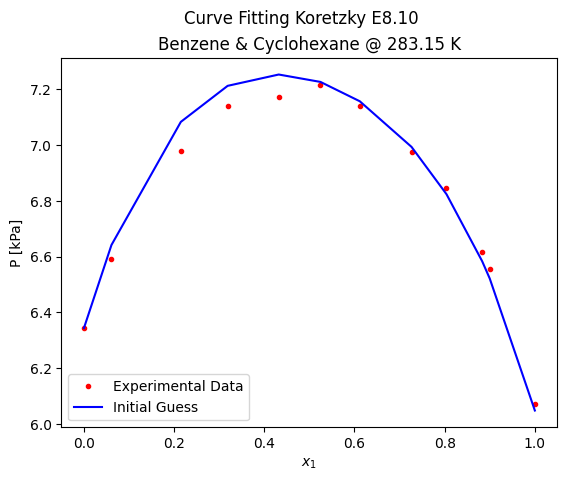

In [ ]:
# plotting shot function
plt.plot(df_KRTZ_8_9['x1'], df_KRTZ_8_9['P[Pa]']*1E-3, 'r.', label='Experimental Data')
plt.plot(df_KRTZ_8_9['x1'], p_calc_init_, 'b-', label='Initial Guess')
plt.ylabel('P [kPa]')
plt.xlabel('$x_1$')
plt.annotate(f'Initial Guess A = {shot_A} J/mol\nInitial Guess B = {shot_B} J/mol', (0.6, 9.5), textcoords="offset points", xytext=(0,10), ha='left')
plt.suptitle('Curve Fitting Koretzky E8.10')
plt.title(f'Benzene & Cyclohexane @ {T} K')
plt.legend(loc='best');

In [ ]:
# obtaining optimal values
popt_, pcov_ = curve_fit(p_calc_, df_KRTZ_8_9['x1'], df_KRTZ_8_9['P[Pa]']*1E-3, [shot_A, shot_B])
print(f'Optimal value for A={round(popt_[0],2)} J/mol\nOptimal value for B={round(popt_[1],2)} J/mol')

Optimal value for A=1470.45 J/mol
Optimal value for B=-43.2 J/mol


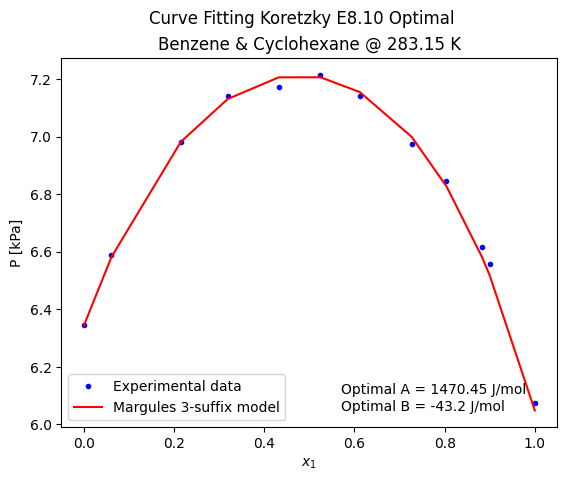

In [ ]:
# plotting with new and optimal values for A & B
plt.plot(df_KRTZ_8_9['x1'], df_KRTZ_8_9['P[Pa]']*1E-3, 'b.', label='Experimental data')
plt.plot(df_KRTZ_8_9['x1'], p_calc_(df_KRTZ_8_9['x1'], popt_[0], popt_[1]), 'r-', label='Margules 3-suffix model')
plt.annotate(f'Optimal A = {round(popt_[0],2)} J/mol\nOptimal B = {round(popt_[1],2)} J/mol', (0.57, 6.), textcoords="offset points", xytext=(0,10), ha='left')
plt.xlabel('$x_1$')
plt.ylabel('P [kPa]')
plt.legend(loc='best')
plt.suptitle('Curve Fitting Koretzky E8.10 Optimal')
plt.title(f'Benzene & Cyclohexane @ {T} K');

In [ ]:
p_calc_opt_ = p_calc_(df_KRTZ_8_9['x1'], popt_[0],popt_[1])
sum_of_errors = [(df_KRTZ_8_9['P[Pa]'][i]*1E-3 - p_calc_opt_[i])**2 for i in range(len(df_KRTZ_8_9['P[Pa]']))]


print(25*'='+' POST OPTIMIZATION '+25*'=')
# function optimized
p_calc_opt_ = p_calc(df_KRTZ_8_9['x1'], popt_[0])
optimal_ = [(df_KRTZ_8_9['P[Pa]'][i]*1E-3 - p_calc_opt_[i])**2 for i in range(len(df_KRTZ_8_9['P[Pa]']))]
print(f'A={round(popt_[0],2)} J/mol \nB={popt_[1]} J/mol\t SUM OF SQRD ERROR = [{round(sum(optimal_), 2)}]')
print('='*69)

gamma1_opt_ = [((popt_[0]+3*popt_[1])/R/T)*((1-df_KRTZ_8_9['x1'][i])**2) - ((4*popt_[1])/R/T)*((1-df_KRTZ_8_9['x1'][i])**3) for i in range(len(df_KRTZ_8_9['x1']))]
gamma2_opt_ = [(((popt_[0]-3*popt_[1])/R/T)*(df_KRTZ_8_9['x1'][i]**2) + ((4*popt_[1])/R/T)*((df_KRTZ_8_9['x1'][i])**3)) for i in range(len(df_KRTZ_8_9['x1']))]

dataframe_opt = pd.DataFrame({'gamma1 optimal':[i for i in gamma1_opt_],
                               'gamma2 optimal':[i for i in gamma2_opt_],
                               'P[Pa]':[i*1E3 for i in p_calc_opt_],
                               'P²_err':[i for i in optimal_]})
print(dataframe_opt)
print('='*69)

========================= POST OPTIMIZATION =========================
A=1470.45 J/mol 
B=-43.2010106698226 J/mol	 SUM OF SQRD ERROR = [0.02]
    gamma1 optimal  gamma2 optimal        P[Pa]        P²_err
0         0.642984        0.000000  6343.861362  1.922060e-08
1         0.562984        0.002512  6610.664856  4.270363e-04
2         0.386600        0.030661  7036.408563  3.181926e-03
3         0.287595        0.066659  7180.925937  1.674932e-03
4         0.197211        0.120928  7244.837176  5.451929e-03
5         0.136615        0.176455  7235.323314  3.733905e-04
6         0.090177        0.237522  7176.766952  1.351809e-03
7         0.044107        0.330593  7016.607734  1.815419e-03
8         0.022434        0.401210  6842.558822  5.959349e-06
9         0.007915        0.479407  6594.121148  5.234419e-04
10        0.005781        0.496929  6529.796109  7.400517e-04
11        0.000000        0.606281  6047.918373  6.290880e-04


# Bubble Point Calculation with P Known - EXAMPLE 8.1 - Koretsky

Consider a system with liquid containing 30% n-pentane(1), 30% cyclohexane(2), 20% n-hexane(3), 20% n-heptane(4) @ 1 bar. Determine the temperature at which this liquid develops the first bubble of vapor. What's the vapor composition?
  
* @ 1 bar: weak intermolecular forces, assumption of ideal gas.
* Raoult's Law for equilibrium

Modelling:
  
$Raoult's Law:\;\;y_iP=x_iP^{sat}_i$
  
$Antoine's Equation:\;\;Ln\;P^{sat}_i[bar]=A_i-\frac{B_i}{T[K] + C_i}$
  

The sum of the partial pressures equals the system pressures: $P=\sum{y_iP}=\sum x_iP^{sat}_i$


In [ ]:
# data from problem
liquid_composition = np.array([0.3, 0.3, 0.2, 0.2])
P_system = 1 # bar

# shot temperature
T_shot = 300 # K

an_cte = np.array([9.2131, 2477.07, -39.94,
          9.1325, 2766.63, -50.50,
          9.2164, 2697.55, -48.78,
          9.2535, 2911.32, -56.51]).reshape((4, 3))

# objective function
obj_fun = lambda T: np.sum([liquid_composition[i] * np.exp(an_cte[i, 0] - an_cte[i, 1]/(T + an_cte[i, 2])) for i in range(len(liquid_composition))]) - P_system

T_opt, = fsolve(obj_fun, T_shot)
print(f'Temperature of Bubble Point = {round(T_opt,0)} K')

Temperature of Bubble Point = 333.0 K


In [ ]:
# checking vapor phase composition
psat = [np.exp(an_cte[i, 0] - an_cte[i, 1]/(T_opt + an_cte[i, 2])) for i in range(len(liquid_composition))]
vapor_phase_composition = lambda x, Topt: [x[i]*np.exp(an_cte[i, 0] - an_cte[i, 1]/(Topt + an_cte[i, 2]))/P_system for i in range(len(liquid_composition))]
substances = ['n-pentane', 'cyclohexane', 'n-haxane', 'n-heptane']
MW_subs = [72.15, 84.161, 86.177, 100.204] # g/mol

yi = vapor_phase_composition(liquid_composition, T_opt)

for i in zip(substances, yi, psat, MW_subs):
    print(f'{i[0]} = {round(i[1],3)}\tPsat = {round(i[2],3)} bar\tMW = {round(i[3],3)} g/mol')

n-pentane = 0.639	Psat = 2.131 bar	MW = 72.15 g/mol
cyclohexane = 0.154	Psat = 0.514 bar	MW = 84.161 g/mol
n-haxane = 0.151	Psat = 0.756 bar	MW = 86.177 g/mol
n-heptane = 0.056	Psat = 0.278 bar	MW = 100.204 g/mol


As expected, the lighter materials are more evident in the vapor phase than the havier (see $C_5H_{12}$ related to $C_7H_{16}$)